In [14]:
import pandas as pd
data_frame = pd.read_csv('training.csv')
data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from skimage.transform import resize


def data_loader(data_frame):
    
    # Load dataset file
    #data_frame = pd.read_csv('training.csv')
    
    
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    
    imgs_array = imgs_array.astype(np.float32)
    imgs_array = imgs_array.reshape(-1,96, 96)
    imgs_array = np.stack((imgs_array,)*3, axis=-1)
    
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array



x_train, y_train = data_loader(data_frame)

print("Training datapoint shape: X_train.shape:{}".format(x_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))

Training datapoint shape: X_train.shape:(2140, 96, 96, 3)
Training labels shape: y_train.shape:(2140, 30)


In [33]:
from keras.applications import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

def build_model( ):
    input_tensor = Input(shape=(target_size, target_size, 3))
    base_model = MobileNetV2(
        include_top=False,
        weights=None,
        input_tensor=input_tensor,
        input_shape=(target_size, target_size, 3),
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)
    op = Dropout(.25)(op)
    
   
    output_tensor = Dense(30)(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)


    return model

In [39]:
from keras.optimizers import Adam
epochs = 60
batch_size = 64

model = build_model()
model.summary()
hist = tf.keras.callbacks.History()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model1.h5')


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 12, 12, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 12, 12, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 12, 12, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 12, 12, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 6, 6, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 6, 6, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 6, 6, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 6, 6, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 6, 6, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 6, 6, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 6, 6, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 6, 6, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 3, 3, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 3, 3, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 3, 3, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 3, 3, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

27/27 [==============================] - 85s 3s/step - loss: 0.0130 - accuracy: 0.5578 - val_loss: 0.1181 - val_accuracy: 0.4322
Epoch 5/60
27/27 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.5467
Epoch 5: val_loss improved from 0.11811 to 0.11041, saving model to checkpoint1.hdf5
27/27 [==============================] - 83s 3s/step - loss: 0.0109 - accuracy: 0.5467 - val_loss: 0.1104 - val_accuracy: 0.4322
Epoch 6/60
27/27 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.5835
Epoch 6: val_loss improved from 0.11041 to 0.09926, saving model to checkpoint1.hdf5
27/27 [==============================] - 85s 3s/step - loss: 0.0106 - accuracy: 0.5835 - val_loss: 0.0993 - val_accuracy: 0.4322
Epoch 7/60
27/27 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.5999
Epoch 7: val_loss improved from 0.09926 to 0.08900, saving model to checkpoint1.hdf5
27/27 [==============================] - 94s 3s/step - loss: 0.0093 - accura

27/27 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.7669
Epoch 32: val_loss did not improve from 0.01271
27/27 [==============================] - 93s 3s/step - loss: 0.0043 - accuracy: 0.7669 - val_loss: 0.0135 - val_accuracy: 0.4322
Epoch 33/60
27/27 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.7739
Epoch 33: val_loss improved from 0.01271 to 0.01118, saving model to checkpoint1.hdf5
27/27 [==============================] - 92s 3s/step - loss: 0.0042 - accuracy: 0.7739 - val_loss: 0.0112 - val_accuracy: 0.4322
Epoch 34/60
27/27 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.7792
Epoch 34: val_loss did not improve from 0.01118
27/27 [==============================] - 79s 3s/step - loss: 0.0039 - accuracy: 0.7792 - val_loss: 0.0116 - val_accuracy: 0.4322
Epoch 35/60
27/27 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.7617
Epoch 35: val_loss did not improve from 0.01118
27/27 [========

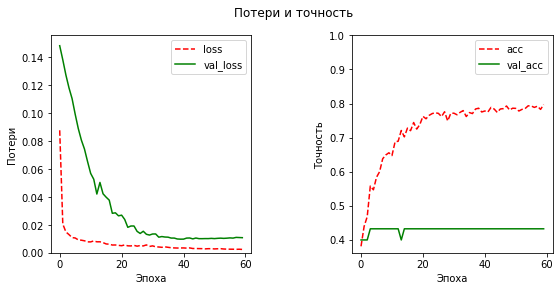

In [76]:
from matplotlib import pyplot as plt
# Вывод графиков 
def one_plot(n, y_lb, loss_acc, val_loss_acc): 
    plt.subplot(1, 2, n) 
    if n == 1: 
        lb, lb2 = 'loss', 'val_loss' 
        yMin = 0 
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc)) 
    else: 
        lb, lb2 = 'acc', 'val_acc' 
        yMin = min(min(loss_acc), min(val_loss_acc)) 
        yMax = 1.0 
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--') 
    plt.plot(val_loss_acc, color = 'g', label = lb2) 
    plt.ylabel(y_lb) 
    plt.xlabel('Эпоха') 
    plt.ylim([0.95 * yMin, yMax]) 
    plt.legend()
    
# Вывод графиков обучения 
plt.figure(figsize = (9, 4)) 
plt.subplots_adjust(wspace = 0.5) 
one_plot(1, 'Потери', model_fit.history['loss'], model_fit.history['val_loss']) 
one_plot(2, 'Точность', model_fit.history['accuracy'], model_fit.history['val_accuracy']) 
plt.suptitle('Потери и точность') 
plt.show()

(96, 96)
(96, 96)
(1, 96, 96)
1/1 [==============================] - 1s 1s/step


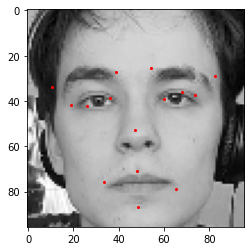

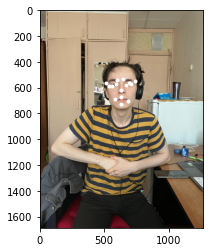

In [78]:

import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('model.h5')  # <-- Saved model path


def detect_points(face_img):
    im  = np.array(face_img)/255
    print(im.shape)
    x_test = np.expand_dims(im, axis=0)
    print(x_test.shape)
    x_test = np.stack((x_test,)*3, axis=-1)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('kharit1.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)


faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    print(just_face.shape)
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=2)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()

 